# 6x6 Sudoku

The task considered in that of solving a 6x6 sudoku by means of imposing constraints on the predictions of the model during training. We do not enforce that the entire predicted sudoku be valid, but rather that every row, column and square have unique elements. If all such constraints are satisfied, we're guaranteed that the predicted sudoku is valid. This case study therefore provides an example of cases where it might be infeasible to enforce a constraint, in which case we can resort to breaking it down into simpler constraints which we can then simultaneously minimize during training.

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
torch.manual_seed(4)

import matplotlib.pyplot as plt
%matplotlib inline

We begin by defining our model. As can be seen our model is just 3D tensor-- each cell in the 6x6 sudkoku can take on any of 6 values

In [3]:
class SudokuSolver(nn.Module):
    def __init__(self, board_size):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand((1,6,6,6)))
        
    def __call__(self, X):
        
        return self.W

# auxiliary functions    
def process_inputs(X):
    
    is_input = X.sum(dim=3, keepdim=True)
    
    X = X.view(X.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)
    
    return is_input

def show_sudoku(X):
    return (torch.argmax(X, 2) + 1) * (X.sum(2).long())

We define our input and target, and unpack them into 3D tensors

In [7]:
X = torch.tensor([[0, 4, 1, 0, 3, 0],
                  [0, 0, 3, 5, 1, 0],
                  [4, 1, 0, 0, 2, 5],
                  [0, 3, 5, 4, 6, 0],
                  [1, 0, 2, 6, 0, 3],
                  [3, 0, 0, 0, 0, 2]])

Y = torch.tensor([[5, 4, 1, 2, 3, 6],
                  [6, 2, 3, 5, 1, 4],
                  [4, 1, 6, 3, 2, 5],
                  [2, 3, 5, 4, 6, 1],
                  [1, 5, 2, 6, 4, 3],
                  [3, 6, 4, 1, 5, 2]])

X_ = torch.zeros((6,6,6))
for i in range(6):
    for j in range(6):
        if X[i][j].item() > 0:
            X_[i][j][X[i][j].item() - 1] = 1        
            
Y_ = torch.zeros((6,6,6))
for i in range(6):
    for j in range(6):
        if Y[i][j].item() > 0:
            Y_[i][j][Y[i][j].item() - 1] = 1
            
X = X_.unsqueeze(0)
Y = Y_.unsqueeze(0)

is_input = process_inputs(X)

input = show_sudoku(X[0])
X = X
Y = Y[0]
is_input = is_input[0]  

In [8]:
# Input
print(show_sudoku(X[0])) # Shape of X_in: (BxHxWxC)

tensor([[0, 4, 1, 0, 3, 0],
        [0, 0, 3, 5, 1, 0],
        [4, 1, 0, 0, 2, 5],
        [0, 3, 5, 4, 6, 0],
        [1, 0, 2, 6, 0, 3],
        [3, 0, 0, 0, 0, 2]])


In [9]:
# Groundtruth
print(show_sudoku(Y[0]))

tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])


We create our model and our optimizer

In [ ]:
model = SudokuSolver(6)
optimizer = optim.SGD(model.parameters(), lr=1.0)

Our constraint function *isunique* enofrces that the number of elements of an input 6x6 tensor, which corresponds to a decoding of the network's output distribution over a row, column or square is unique. We note that our constraint function is a vanilla python function, and does not make use of any custom syntax.

In [6]:
def isunique(X):
    return len(X.unique()) == 6

We import the constraint module and declare isunique_constraint as a constraint that we can enforce at training time. We note that our constraint function.

In [10]:
import sys
sys.path.append("..")

import torch.optim as optim
from pylon.constraint import constraint

isunique_constraint = constraint(isunique)

Finally, we proceed to our normal training loop. Line 10 uses the regular corss entropy loss to learn entries that are fixed in the sudoku. We then proceed enforce the constraint on every row, column and (flattented) square in the 6x6 gridm lines 13, 14 and 18, respectively. Lines 20 through 30 then proceed to define the total loss as a convex combination of the individual constraint losses.

In [12]:
for epoch in tqdm(range(50)):
    row_losses = []
    col_losses = []
    sqr_losses = []

    optimizer.zero_grad()
    
    output = model(X[:1])
    loss = F.cross_entropy(output.view(-1,6), Y.argmax(dim=2).view(-1), reduction='none') * is_input
    
    for i in range(0, 6):
        row_losses += [row_constraint(output[:, i])]
        col_losses += [row_constraint(output[:, :, i])]

    for i in range(0, 6, 2):
        for j in range(0, 6, 3):
            sqr_losses += [row_constraint(output[:, i:i+2, j:j+3].reshape(1,6,6))]
            
    row_losses = torch.stack(row_losses)
    col_losses = torch.stack(col_losses)
    sqr_losses = torch.stack(sqr_losses)
    
    row_multipliers = row_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    col_multipliers = col_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    sqr_multipliers = sqr_losses / (row_losses.sum().data + col_losses.sum().data + sqr_losses.sum().data)
    
    row_loss = (row_losses * row_multipliers).sum()
    col_loss = (col_losses * col_multipliers).sum()
    sqr_loss = (sqr_losses * sqr_multipliers).sum()
    
    total_loss = loss.sum() + row_loss + col_loss + sqr_loss

    total_loss.backward()

    optimizer.step()

100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


As we can observe, the model converges to the correct sudoku after 50 iterations

In [23]:
output = model(X[:1])

print("Predicted Sudoku:")
print((output[0].argmax(dim =-1) + 1).data)
print()

print("Groundtruth Sudoku:")
print(show_sudoku(Y))


Predicted Sudoku:
tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])

Groundtruth Sudoku:
tensor([[5, 4, 1, 2, 3, 6],
        [6, 2, 3, 5, 1, 4],
        [4, 1, 6, 3, 2, 5],
        [2, 3, 5, 4, 6, 1],
        [1, 5, 2, 6, 4, 3],
        [3, 6, 4, 1, 5, 2]])


This is confirmed by the below heatmap showing cells where the prediction matches (blue) or doesn't (white) the groundtruth

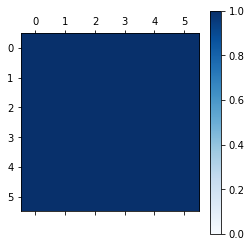

In [19]:
heatmap = plt.matshow((output[0].argmax(dim =-1) == Y.argmax(dim=-1)), cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar(heatmap)